# Glassdoor HR Review Detector

# 1. Theory

- The kinds of words that genuine employees use in glassdoor review is different from the one used by HR.
- So my theory is that I can use AI to distinguist between these two kind of reviews.
- This will be achived using embeddings. An embedding is a coversion of natural language to vectors. Vectors of similar words are close to each other. My theory is that one or more regions of of the vector space are more of the human resources kind while other regions are more of the genuine employee kinds.
- My goal is to train a neural network to identify regions in the vector space that are "hr"-ish vs. regions that are "genuine"-ish. Based on this, given a review text, the network will be able to predict if the review was written by HR or not.


- Training data consists of pros, cons, overall review, sounds like hr
- pros, cons represented as vector embeddings using openai api

> **NOTE**: How is the `sounds_like_hr` field set in the training data? The answer is that I set it based on my gut instinct! **Please do not take this project seriously**, it's just an excuse to try out machine learning algorithms. For context: I used Glassdoor in the past and suspected some reviews were written by HR; either because they would say there are no cons or they would pander to the company like 'you have to work late, but it's worth it'. I thought it would be a fun project to build an AI that could detect this based on my instinct rather than emperical data.

## 1.1 Quick Experiment

A quick experiment to see if my theory has some merit is the following:
1. Take a subset of training data
1. Divide training data into training set, test set.
1. Convert  reviews in the training set to embeddings
1. Store the embeddings in an in-memory vector store.
1. Query the vector store with genuine review (from the test set) ... should return other reviews that sound genuine
1. Query the vector store with hr review (from the test set) ... should return other reviews that sound hr.



In [26]:
import csv
import tempfile
from IPython.display import display, HTML
from utils.utils import load_csv_as_dictionary, array_of_dictionaries_to_csv_string
from sklearn.model_selection import train_test_split
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_chroma import Chroma
import pandas as pd

InteractiveShell.ast_node_interactivity = "all"

In [18]:
# 1. load csv as array of objects 
data = load_csv_as_dictionary(csv_filename='training-data/glassdoor-reviews-main.csv')
for item in data:
    item['sounds_like_hr'] = int(item['sounds_like_hr'])

# 2. use scikit learn to split into training and test set?
training_set, test_set = train_test_split(data, test_size=0.40, random_state=1)

# 3. Format training set into csv

training_set_csv = array_of_dictionaries_to_csv_string(training_set)

    
# 4. embed training set openai API and store in in-memory vector db
with tempfile.NamedTemporaryFile(delete=False, mode="w+") as temp_file:
    temp_file.write(training_set_csv)
    temp_file_path = temp_file.name

loader = CSVLoader(file_path=temp_file_path)
documents = loader.load()
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [16]:
def extract_lines_between(multiline_string, start_marker, end_marker):
    lines = multiline_string.splitlines()
    start_index, end_index = -1, -1
    
    for index, line in enumerate(lines):
        if line.strip().lower().startswith(start_marker.lower()):
            start_index = index
        elif line.strip().lower().startswith(end_marker.lower()) and start_index != -1:
            end_index = index
            break
    
    if start_index != -1 and end_index != -1:
        return "\n".join(lines[start_index:end_index])
    else:
        return None

In [15]:
review_genuity_dict = {item["id"]: item["sounds_like_hr"] for item in data}

total_genuine_reviews_in_test_set = 0
# Incremented when a genuine review in the test set matches a genuine review in the training set.
correctly_matched_genuine_revews = 0

total_hr_reviews_in_test_set = 0
# Incremented when a hr review in the test set matches a hr review in the training set.
correctly_matched_hr_revews = 0

table = {
    'Query Review Id':[], 
    'Query Review': [], 
    'Query review written by hr?': [], 
    'Matching Review Id': [], 
    'Matching Review': [],
    'Matching Review written by hr?': []
}

for test_review in test_set:
    
    test_review_id = test_review['id']
    test_review_sounds_like_hr = review_genuity_dict[test_review_id] == 1
    
    if test_review_sounds_like_hr:
        total_hr_reviews_in_test_set += 1
    else:
        total_genuine_reviews_in_test_set += 1
    
    query = test_review['cons']
    
    docs = db.similarity_search(query)
    first_result = docs[0].page_content
    training_review_id = document_lines[0].split(": ")[1]
    trainingt_review_sounds_like_hr = review_genuity_dict[training_review_id] == 1

    pros = extract_lines_between(first_result,"pros:","cons:")
    cons = extract_lines_between(first_result,"cons:","sounds_like_hr:")
    
    if review_genuity_dict[training_review_id] == review_genuity_dict[test_review_id]:
        if test_review_sounds_like_hr:
            correctly_matched_hr_revews += 1
        else:
            correctly_matched_genuine_revews += 1

    table['Query Review Id'].append(test_review_id)
    table['Query review written by hr?'].append(test_review_sounds_like_hr)
    table['Matching Review Id'].append(training_review_id)
    table['Matching Review'].append(cons)
    table['Matching Review written by hr?'].append(trainingt_review_sounds_like_hr)
    table['Query Review'].append(query)

In [27]:
df = pd.DataFrame(table)
display(HTML(df.to_html()))

,Query Review Id,Query Review,Query review written by hr?,Matching Review Id,Matching Review,Matching Review written by hr?
0,empReview_41321460,Racism and no inclusion of non Indian employees.,False,empReview_25845845,cons: Prejudice and Racism from the highest levels of Executive Management. I have witnessed Senior Executives threatening employees verbally and physically. The attrition rates at Company are due to an incompetent structure where people reward incompetence rather than quality work.\n\nThe company works on a policy of fear and retaliation. Middle Management seems to take pride in underpaying employees. \n\nI have witnessed the HR department demand that operational staff and warehouse employees take paycuts to their already limited monthly salaries. All the while they move to pay lazy unsuccessful office staff more money.\n\nDO NOT LEAVE YOUR COMPANY TO WORK FOR COMPaNY.,False
1,empReview_76243429,none. adding some benefits for employees would be nice,False,empReview_29216244,cons: No transparency\nNo clear vision\nNo value of the employees after change in management.\nNo clear work process,False
2,empReview_18624562,"It is more like a shark tank , the mass is what really matter , not the qualification",False,empReview_88730231,cons: Cut throat. Performance based on who shouts it out more,False
3,empReview_89721438,Analysis and experiments are basic,False,empReview_85226573,cons: - A lot of adhoc work as a data analyst,False
4,empReview_86888638,"Management is too poor and weak, and leadership are so arrogant and bossy.",False,empReview_34457480,"cons: Leadership team appear to be clueless and it feels like they're not competent enough to run a company as big as company. \n\nNot only that but even their managerial soft skills are appalling. Employees are demotivated,underpaid, understaffed and under stress with insane work load with low morale. \n\nMany smart and incredibly competent people are leaving only to be replaced by incompetent and cheaper employees which adds more stress and burden on other employees.",False
5,empReview_82927529,Stressful as my time there the company direction was still not very clear,False,empReview_59213783,cons: The teams were recently reshuffled so there was some unclarity with regards to the responsibilities,False
6,empReview_89696246,a little stressful at times,True,empReview_17765375,cons: such comfy place give you a motivation,True
7,empReview_90451544,You need to be prepared for a high work load with limited support sometimes,False,empReview_17494789,cons: Work under pressure! but its worth it.,False
8,empReview_32494277,"HR has no clue about anything and never gives a direct answer! HR is present in most meetings but doesn’t say a single word. If a question is asked to HR, the standard response is “I’ll check and get back”. Why is that always the answer? Why so clueless? Take charge! Check with who? Might as well cut out the “middle man” and let the employees straight up ask the person who HR is asking.",False,empReview_59213783,cons: The teams were recently reshuffled so there was some unclarity with regards to the responsibilities,False
9,empReview_28035149,Pay & appreciation\npolitics \nLong working hours,False,empReview_67123050,cons: They do appreciate the effort,True


In [25]:
print(f"Genuine Score: {correctly_matched_genuine_revews}/{total_genuine_reviews_in_test_set} = {(correctly_matched_genuine_revews/total_genuine_reviews_in_test_set)*100}")
print(f"HR Score: {correctly_matched_hr_revews}/{total_hr_reviews_in_test_set} = {(correctly_matched_hr_revews/total_hr_reviews_in_test_set)*100}")

Genuine Score: 105/112 = 93.75
HR Score: 17/29 = 58.620689655172406


### Error Analysis

The goal of this experiment was to see if reviews that seemed like they were writtn by HR use the same kind of language (which would result in matches when querying in a vector database). The only field that was considered for this experiment was the 'cons' field.

We do see some instances of this in the table e.g. "no cons" , "Few peoples are not working hard they will down value of company and team members." It's difficult to conclude because the test set only contained 7 reviews that seemed like they were written by HR. Should repeat this experiment with a larger data sample.

What we also see is that HR cons section tend to shorter than genuine ones, and frequently share the pr-friendly con "long hours, startups are choatic" e.t.c . We only considered the "cons" field, but when we combine this with the rating field, I feel that an AI model would be able to pick up on these differences and therefore be able to classify a review that looks like it was written by HR.

In short:
1. Need to try this experiemnt with a larger data set.
2. There are indications that a model might be able to classify this.


# 2. Visualising the Embeddings

We will compare the embeddings of pros and cons of genuine and HR written reviews to see their relative position in the embedding vector space. 

Given my observation that either:
- HR written cons claim there aren't any e.g. "no cons", "Can't think of any, really.", "nothing to mention everything is going great"
- HR written cons tend to be PR friendly e.g. "you'll need to work late but that is expected for a startup"
Then
- The embedding of HR cons will have some specific clusters, corresponding to e.g. "no cons" and/or "late sittings"
- The embedding of HR cons will overlap with pros.

First, let's see what embeddings look like

In [4]:
from chromadb.utils import embedding_functions
import numpy as np
default_ef = embedding_functions.DefaultEmbeddingFunction()

genuine_pros = [i['pros'] for i in list(filter(lambda t : t['sounds_like_hr'] == 0, data))]
genuine_cons = [i['cons'] for i in list(filter(lambda t : t['sounds_like_hr'] == 0, data))]
hr_pros = [i['pros'] for i in list(filter(lambda t : t['sounds_like_hr'] == 1, data))]
hr_cons = [i['cons'] for i in list(filter(lambda t : t['sounds_like_hr'] == 1, data))]

genuine_pros_matrix = np.array(default_ef(genuine_pros))
genuine_cons_matrix = np.array(default_ef(genuine_cons))
hr_pros_matrix = np.array(default_ef(hr_pros))
hr_cons_matrix = np.array(default_ef(hr_cons))

print(f"Geninuine Pros Embedding Shape: {genuine_pros_matrix.shape}")
print(f"Geninuine Cons Embedding Shape: {genuine_cons_matrix.shape}")
print(f"HR Pros Embedding Shape: {hr_pros_matrix.shape}")
print(f"HR Cons Embedding Shape: {hr_cons_matrix.shape}")

Geninuine Pros Embedding Shape: (283, 384)
Geninuine Cons Embedding Shape: (283, 384)
HR Pros Embedding Shape: (68, 384)
HR Cons Embedding Shape: (68, 384)


## 2.1 Principal Component Analysis

We can see here that each review has 384 parameters. In order to visualise the relative position of embeddings, we will need to perform principal component analysis


In [10]:
from sklearn.decomposition import PCA

# Loading the PCA algorithm
pca_2 = PCA(n_components=2)
# Let's fit the data. We do not need to scale it, since sklearn's implementation already handles it.
pca_2.fit(genuine_pros_matrix)
print(f"Explained Variance Ratio: {pca_2.explained_variance_ratio_}")

genuine_pros_2d = pca_2.transform(genuine_pros_matrix)
genuine_cons_2d = pca_2.transform(genuine_cons_matrix)
hr_pros_2d = pca_2.transform(hr_pros_matrix)
hr_cons_2d = pca_2.transform(hr_cons_matrix)
print(genuine_pros_2d.shape)
print(genuine_cons_2d.shape)
print(hr_pros_2d.shape)
print(hr_cons_2d.shape)

Explained Variance Ratio: [0.05642524 0.0492189 ]
(283, 2)
(283, 2)
(68, 2)
(68, 2)


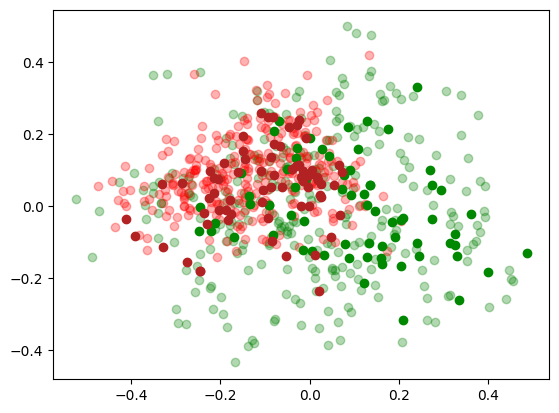

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

xgp = [x for x,y in genuine_pros_2d]
ygp = [y for x,y in genuine_pros_2d]
xgc = [x for x,y in genuine_cons_2d]
ygc = [y for x,y in genuine_cons_2d]

xhp = [x for x,y in hr_pros_2d]
yhp = [y for x,y in hr_pros_2d]
xhc = [x for x,y in hr_cons_2d]
yhc = [y for x,y in hr_cons_2d]

plt.scatter(xgp, ygp, c='green', alpha=0.3)
plt.scatter(xgc, ygc, c='red', alpha=0.3)
plt.scatter(xhp, yhp, c='#008800')
plt.scatter(xhc, yhc, c='#b22222')

*Note: While researching, I came across something called [TSNE](https://cookbook.openai.com/examples/visualizing_embeddings_in_2d). Saving it here to study more about it later.*